In [561]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [562]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

In [563]:
import pyqsofit
from pyqsofit.PyQSOFit import QSOFit
print(pyqsofit.__version__)

2.0.0


In [564]:
from scipy.stats import median_abs_deviation

In [565]:
flux_cal = False

## Setup PyQSOFit

In [566]:
path_ex = os.path.join('.')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Hengxiao Guo'
primary_hdu = fits.PrimaryHDU(header=hdr0)

In [567]:
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""

newdata = np.rec.array([
    (6564.61, 'Ha', 6400, 6800, 'Ha_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (6564.61, 'Ha', 6400, 6800, 'Ha_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169/2, 0.01, 1, 1, 0, 0.002, 1),
    (6549.85, 'Ha', 6400, 6800, 'NII6549', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 5e-3, 1, 1, 1, 0.001, 1),
    (6585.28, 'Ha', 6400, 6800, 'NII6585', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 5e-3, 1, 1, 1, 0.003, 1),
    (6718.29, 'Ha', 6400, 6800, 'SII6718', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 5e-3, 1, 1, 2, 0.001, 1),
    (6732.67, 'Ha', 6400, 6800, 'SII6732', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 5e-3, 1, 1, 2, 0.001, 1),

    (4862.68, 'Hb', 4640, 5100, 'Hb_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01, 1),
    (4862.68, 'Hb', 4640, 5100, 'Hb_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 0.01, 1, 1, 0, 0.002, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 0.01, 1, 1, 0, 0.002, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007c', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2, 0.01, 1, 1, 0, 0.004, 1),
    (4960.30, 'Hb', 4640, 5100, 'OIII4959w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
    (5008.24, 'Hb', 4640, 5100, 'OIII5007w',   1, 0.0, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
    #(4687.02, 'Hb', 4640, 5100, 'HeII4687_na', 1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169, 0.005, 1, 1, 0, 0.001, 1),

    (4341.68, 'Hg', 4310, 4370, 'Hg_na',   1, 0.0, 0.0, 1e10, 1e-3, 2.3e-4, 0.00169/2,  0.01,  0, 1, 0, 0.002, 1),
    (4341.68, 'Hg', 4310, 4370, 'Hg_br',   1, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.01, 0, 0, 0, 0.01, 1),

    (3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169/2, 0.01, 99, 0, 0, -0.001, 1),

    (3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169/2, 0.01, 1, 1, 0, 0.001, 1),

    (3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.0, 0.0, 1e10, 1e-3, 3.333e-4, 0.00169/2, 0.01, 0, 0, 0, 0.001, 1),
    (3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

    (2798.75, 'MgII', 2700, 2900, 'MgII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    (2798.75, 'MgII', 2700, 2900, 'MgII_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169/2, 0.01, 1, 1, 0, 0.002, 1),

    (1908.73, 'CIII', 1700, 1970, 'CIII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
    #(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.0, 0.0, 1e10, 1e-3, 5e-4,  0.00169, 0.01,  1, 1, 0, 0.002, 1),
    #(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
    #(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

    (1549.06, 'CIV', 1500, 1700, 'CIV_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    # (1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

    (1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    (1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
    #(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
    #(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

    (1215.67, 'Lya', 1150, 1290, 'Lya_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05, 0.02, 0, 0, 0, 0.05, 1),
    (1240.14, 'Lya', 1150, 1290, 'NV1240', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.01, 0.005, 0, 0, 0, 0.002, 1),
    (1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 0, 0, 0.002, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=newdata, header=hdr1, name='line_priors')

In [568]:
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    (900., 1170.), 
    (1275., 1290.),
    (1350., 1360.),
    (1445., 1465.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3400.),
    (3500., 3610.),
    (3775., 3832.),
    (4000., 4050.),
    (4200., 4230.),
    (4435., 4640.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    (6800., 7000.),
    (7160., 7180.),
    (7500., 7800.),
    (8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  1), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 1), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     1.0,   0.0,   1e8,  1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   1), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  1), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 1), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.5,   0.1,   2.0,   1), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',  0, -1e10, 1e2,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',  0, -1e10, 1e2,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',  0, -1e10, 1e2,  1), # 3rd coefficient of the polynomial continuum
    # TODO: In a future version, we may add options to add more if you want...
    # ('conti_pl_3',  0.0,  -1e10,  1e10,  1), # 4th coefficient of the polynomial continuum
    # ('conti_pl_4',  0.0,  -1e10,  1e10,  1), # 5th coefficient of the polynomial continuum
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

In [569]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""
cont_loc = [1350, 1450, 2200, 3000, 4200, 5100]
BC =       [9.26, 9.26, 9.26, 5.15, 5.15, 3.81]
measure_info = Table(
    [
        [[1350, 1450, 2200, 3000, 4200, 5100]],
        [[
            # [2240, 2650], 
            [4435, 4685],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto('/Users/colinburke/research/dwarf_agn_cosmos/qsopar.fits', overwrite=True)

In [570]:
fits.open('/Users/colinburke/research/dwarf_agn_cosmos/qsopar.fits')

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2a7519e10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x14ec6a690>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x13c92c390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x281ad2990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2839e57d0>]

## Fit the spectra

In [571]:
data_agn_updated = ascii.read('hsc_agn_updated.txt')

ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']
data_coords = SkyCoord(ra, dec, unit=[u.deg, u.deg])

Pipeline to loop through each source, get the spectrum (if there is one), and fit it.

In [572]:
def calc_M_BH_vir(logL, FWHM_line, FWHM_res=69, line_name='Ha', method='conti'):
    """
    Calculate the single-epoch (virial) black hole mass from the
    continuum luminosity and broad line FWHM
    
    Parameter:
    ----------
    logL: float
        log10 of the continuum or broad-line line luminosity in erg / s
        
    FWHM: float
        broad line FWHM in km / s

    line_name: str

    method: str
    
    Return:
    -----------
    Computed black hole mass M_BH,vir in Solar masses    
    
    "This approach assumes that the broad-line region (BLR)
    is virialized, the continuum luminosity is used as a proxy
    for the BLR radius, and the broad line width (FWHM) is used
    as a proxy for the virial velocity." -- Shen et al. (2011)
    """
    
    key = line_name.split('_')[0] # Remove the _br

    if method == 'conti':
        
        #    VP06           S11            VP06
        a = {'Hb': 0.910 , 'MgII': 0.740, 'CIV':0.660}
        b = {'Hb': 0.50,   'MgII': 0.62,  'CIV':0.53}

    elif method == 'line':

        a = {'Hb': 1.63 , 'MgII': 1.70, 'CIV':1.52}
        b = {'Hb': 0.49,  'MgII': 0.63, 'CIV':0.46}
    
    # Subtract component from instrumental broadening
    FWHM = np.sqrt(FWHM_line**2 - FWHM_res**2)
    
    return a[key] + b[key]*(logL-44) + 2*np.log10(FWHM)

In [573]:
import pickle

def flux_calib(ID, wave, flux, flux_err):

    if flux_cal == False:
        return flux, flux_err, 0

    else:

        # Convert spectrum to photometry
        # bands: 
        filter_dir = '/Users/colinburke/research/cigale-v2022.1/pcigale/data/filters'
    
        #TODO: Add y, JHK
        bands = ['cfht.megacam.u', 'subaru.hsc.g', 'subaru.hsc.r', 'subaru.hsc.i', 'subaru.hsc.z',
                'subaru.hsc.y', 'vista.vircam.Y', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks']
        # Get the COSMOS2020 photometry
        dat_phot = Table.read('/Users/colinburke/research/dwarf_agn_cosmos/cigale/hsc/phot.dat', format='ascii')
    
        rs = np.full(len(bands), np.nan)
        fluxes_e = np.full(len(bands), np.nan)
    
        # Convert cigale filter to pyphot filter and get the spectrophotometric flux
        for i, band in enumerate(bands):
    
            with open(os.path.join(filter_dir, f'name={band}.pickle'), 'rb') as pickle_file:
                filter_ = pickle.load(pickle_file)
                wl = filter_.wl
                tr = filter_.tr
                lambda_piv = filter_.pivot
            # Convert flux 
            mask_f = np.isfinite(flux) & (flux > 0)
            #f_l = (flux[mask_f]*1e-17*u.erg/u.s/u.cm**2/u.AA).to(u.W/u.m**2/u.nm, equivalencies=u.spectral_density(wave[mask_f]*u.AA)).value
            # Interpolate to a grid
            if (len(flux[mask_f]) > 0):
                if (np.min(wave[mask_f]/10) < lambda_piv+50) & (np.max(wave[mask_f]/10) > lambda_piv-50):
                    f_l = (flux[mask_f]*1e-17*u.erg/u.s/u.cm**2/u.AA).to(u.W/u.m**2/u.nm, equivalencies=u.spectral_density(wave[mask_f]*u.AA)).value
                    wl_grid = np.arange(np.min(wave[mask_f]/10), np.max(wave[mask_f]/10), 1)
                    tr_grid = np.interp(wl_grid, wl, tr)
                    f_l_grid = np.interp(wl_grid, wave[mask_f]/10, f_l)
                    # # Fλ flux density in W/m²/nm
                    # We compute directly Fν from ∫T×Fλ×dλ
                    # Normalisation is such that the results we obtain are directly in mJy
                    # https://gitlab.lam.fr/cigale/cigale/-/blob/master/pcigale/sed/__init__.py?ref_type=heads
                    flux_spectro = np.trapz(tr_grid * f_l_grid, x=wl_grid)
                    #plt.errorbar(np.mean(wl), flux_spectro, marker='o', markersize=20, color='gray')
                    ft = (flux[mask_f]*1e-17*u.erg/u.s/u.cm**2/u.AA).to(u.mJy, equivalencies=u.spectral_density(wave[mask_f]*u.AA)).value
                    #plt.plot(wl_grid, np.interp(wl_grid, wave[mask_f]/10, ft), color='k')
                    # Get photometry
                    if ID in dat_phot['id']:
                        print('have photometry')
                        flux_band = dat_phot[band][dat_phot['id']==ID][0]
                        fe = dat_phot[band+'_err'][dat_phot['id']==ID][0]
                        if fe > 0:
                            plt.errorbar(np.mean(wl), flux_band, yerr=fe, marker='o', markersize=20, color='orange')
                        #print(band)
                        #print('flux-band:',flux_band)
                        #print('flux_e-band:',fe)
                        #print('flux-spectro-band:',flux_spectro)
                        if (len(dat_phot[band][dat_phot['id']==ID]) > 0) & (fe > 0):
                            fluxes_e[i] = fe
                        if (flux_band > 0) & (flux_spectro > 0):
                            rs[i] = flux_band/flux_spectro
                    else:
                        print('NO COSMOS2020 optical PHOTOMETRY')
                        return flux, flux_err, 0
    
        # TODO: flag unable to flux calibrate error weighted
        mask = (rs > 0) & np.isfinite(rs) & np.isfinite(fluxes_e)
        if len(rs[mask]) == 0:
            print(f'WARNING: unable to flux calibrate {ID}')
            return flux, flux_err, 0
        r = np.average(rs[mask], weights=1/fluxes_e[mask])
        print('flux-weighted mean:',r)
        print('rs:',rs[mask])
        
        plt.plot(wl_grid, np.interp(wl_grid, wave[mask_f]/10, ft)*r, color='r')
        plt.show()

        # TODO: Flag unable to flux calibrate
        return flux*r, flux_err*r, 1
        

In [596]:
def measureMBH(ID, src, z, wave, flux, flux_err):
    fill = np.full(len(data_agn_BH.colnames)-1, -1.0)
    # Add a row to the table
    data_agn_BH.add_row(np.concatenate(([ID], fill)))
    
    name = 'ID = '+str(ID) + ',' + str(src)

    plt.plot(wave, flux)
    plt.plot(wave, flux_err)
    
    # Prepare data
    try:
        q_noFeII = QSOFit(wave, flux, flux_err, z, path=path_ex)
        q_noFeII.Fit(name=name, nsmooth=1, deredden=True, reject_badpix=True,  #wave_range= np.array([1000, 11000]), \
              wave_mask=None, decompose_host=True, BC03=True, BC=False, npca_gal=15, npca_qso=5, \
              Fe_uv_op=False, poly=True, rej_abs_conti=True, rej_abs_line=True, MC=False, nsamp=200, linefit=True, \
              plot_fig=False, save_result=False, kwargs_plot={'save_fig_path': '.', 'plot_br_prop':True},
              save_fits_name=None, verbose=False, save_fig=True, param_file_name='/Users/colinburke/research/dwarf_agn_cosmos/qsopar.fits')
    except:
        plt.plot(wave, flux)
        plt.plot(wave, flux_err)
        print('FAILED TO FIT')
        return
    
    ## IF the chi2 is really bad > 10, remove Fe II and try again
    q_FeII = QSOFit(wave, flux, flux_err, z, path=path_ex)
    q_FeII.Fit(name=name, nsmooth=1, deredden=True, reject_badpix=True,  #wave_range= np.array([1000, 11000]), \
              wave_mask=None, decompose_host=True, BC03=True, BC=False, npca_gal=15, npca_qso=5, \
              Fe_uv_op=True, poly=True, rej_abs_conti=True, rej_abs_line=True, MC=False, nsamp=200, linefit=True, \
              plot_fig=False, save_result=False, kwargs_plot={'save_fig_path': '.', 'plot_br_prop':True},
              save_fits_name=None, verbose=False, save_fig=True, param_file_name='/Users/colinburke/research/dwarf_agn_cosmos/qsopar.fits')

    # Use Fe II it if chi2 improves by ~20%
    if (q_noFeII.conti_fit.redchi - q_FeII.conti_fit.redchi)/q_FeII.conti_fit.redchi > 0.2:
        q = q_FeII
        print('use Fe ii')
    else:
        q = q_noFeII

    # TODO: consider error 
    Lconti = -1
    Lbol = -1

    data_agn_BH['SNR'][-1] = q.SN_ratio_conti
    data_agn_BH['src'][-1] = src
    
    try:
        if ID==227:
            fig, ax = plt.subplots(figsize=(15, 5))

            # Plot the quasar rest frame spectrum after removed the host galaxy component
            ax.plot(q.wave, q.flux, 'k', label='Data')
            
            # Skip the error results before plotting
            if q.MCMC == True:
                gauss_result = q.gauss_result[::2]
            else:
                gauss_result = q.gauss_result
            
            # To plot the whole model, we use Manygauss to show the line fitting results saved in gauss_result
            ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result) + q.f_conti_model, 'b', label='Line',
                    lw=2)
            ax.plot(q.wave, q.PL_poly_BC, 'orange', lw=2, label='Continuum')
            ax.plot(q.wave, q.qso, 'pink', lw=2, label='Host+QSO Template')
            ax.plot(q.wave, q.host, 'm', lw=2, label='Host')
            plt.legend(fontsize=12, loc=4, frameon=True)
            
            ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
            ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

            line_cen = np.array(
                [6564.60, 6549.85, 6585.27, 6718.29, 6732.66, 4862.68, 5008.24, 4687.02, 4341.68, 3934.78, 3728.47,
                 3426.84, 2798.75, 1908.72, 1816.97, 1750.26, 1718.55, 1549.06, 1640.42, 1402.06, 1396.76, 1335.30, \
                 1215.67])
            
            line_name = np.array(
                ['', '', r'H$\alpha$+[NII]', '', '[SII]6718,6732', r'H$\beta$', '[OIII]', 'HeII4687', r'H$\gamma$', 'CaII3934', '[OII]3728',
                 'NeV3426', 'MgII', 'CIII]', 'SiII1816', 'NIII]1750', 'NIV]1718', 'CIV', 'HeII1640', '', 'SiIV+OIV',
                 'CII1335', r'Ly$\alpha$'])
            
            # Line position
            axis_to_data = ax.transAxes + ax.transData.inverted()
            points_data = axis_to_data.transform((0, 0.92))

            for ll in range(len(line_cen)):
                if q.wave.min() < line_cen[ll] < q.wave.max():
                    ax.axvline(line_cen[ll], color='k', linestyle=':')
                    # ax.plot([line_cen[ll], line_cen[ll]], ylims, 'k:')
                    ax.text(line_cen[ll] + 7, points_data[1], line_name[ll], rotation=90, fontsize=10, va='top')

            ax.set_xlim(np.min(q.wave), np.max(q.wave))
            ax.set_ylim(-0.8, 1.4)
            fig.tight_layout()
            fig.savefig(f'spec{src}.pdf', dpi=300)
            
        ###
        q.plot_fig(plot_br_prop=True, save_fig_path='/Users/colinburke/research/dwarf_agn_cosmos/spec/fits')
        plt.show()
    except:
        print('bad spec!')

    for k, c in enumerate(cont_loc):
        Lconti = float(q.conti_result[q.conti_result_name==f'L{c}'][0])
        if Lconti > 0:
            data_agn_BH['Lconti'][-1] = Lconti
        print(c, q.conti_result[q.conti_result_name==f'L{c}'])
        Lbol = np.log10(BC[k]*10**Lconti)
        if Lbol > 0:
            data_agn_BH['Lbol'][-1] = Lbol

    M_BH_Hbs = []
    M_BH_MgIIs = []
    M_BH_CIVs = []

    M_BH_Hbs_line = []
    M_BH_MgIIs_line = []
    M_BH_CIVs_line = []

    Lconti = data_agn_BH['Lconti'][-1]
    print('Lconti', Lconti)
    
    for j in range(1):
        line_name = 'Hb_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad') #, sample_index=i)
        print('Hb', fwhm)
        if snr > 2:
            M_BH_Hbs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
            M_BH_Hbs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))

        line_name = 'MgII_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad') #, sample_index=i)
        print('MgII', fwhm)
        if snr > 2:
            M_BH_MgIIs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
            M_BH_MgIIs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))

        line_name = 'CIV_br'
        fwhm, sigma, ew, peak, area, snr = q.line_prop_from_name(line_name, line_type='broad') #, sample_index=i)
        print('CIV', fwhm)
        if snr > 2:
            M_BH_CIVs.append(calc_M_BH_vir(Lconti, fwhm, line_name=line_name))
            M_BH_CIVs_line.append(calc_M_BH_vir(np.log10(q.flux2L(area)), fwhm, line_name=line_name, method='line'))
        

    # Line calculations
    data_agn_BH['M_Hb'][-1] = np.median(M_BH_Hbs)
    data_agn_BH['M_MgII'][-1] = np.median(M_BH_MgIIs)
    data_agn_BH['M_CIV'][-1] = np.median(M_BH_CIVs)

    data_agn_BH['M_Hb_line'][-1] = np.median(M_BH_Hbs_line)
    data_agn_BH['M_MgII_line'][-1] = np.median(M_BH_MgIIs_line)
    data_agn_BH['M_CIV_line'][-1] = np.median(M_BH_CIVs_line)

    data_agn_BH['M_Hb_e'][-1] = np.std(M_BH_Hbs)
    data_agn_BH['M_MgII_e'][-1] = np.std(M_BH_MgIIs)
    data_agn_BH['M_CIV_e'][-1] = np.std(M_BH_CIVs)

    data_agn_BH['M_Hb_line_e'][-1] = np.std(M_BH_Hbs_line)
    data_agn_BH['M_MgII_line_e'][-1] = np.std(M_BH_MgIIs_line)
    data_agn_BH['M_CIV_line_e'][-1] = np.std(M_BH_CIVs_line)

    # Pick fiducial BH mass for each spectrum:
    if np.isfinite(data_agn_BH['M_Hb'][-1]) & (data_agn_BH['M_Hb'][-1] > 0):
        data_agn_BH['M'][-1] = data_agn_BH['M_Hb'][-1]
    elif np.isfinite(data_agn_BH['M_MgII'][-1]) & (data_agn_BH['M_MgII'][-1] > 0):
        data_agn_BH['M'][-1] = data_agn_BH['M_MgII'][-1]
    elif np.isfinite(data_agn_BH['M_CIV'][-1]) & (data_agn_BH['M_CIV'][-1] > 0):
        data_agn_BH['M'][-1] = data_agn_BH['M_CIV'][-1]
    
    #### Save the figures here
    print('MASS')
    return


ID:: 1
ID:: 2
ID:: 3
ID:: 4
ID:: 5
ID:: 6
ID:: 7
ID:: 8
ID:: 9
ID:: 10
ID:: 11
ID:: 12
ID:: 13
ID:: 14
ID:: 15
ID:: 16
ID:: 17
ID:: 18
ID:: 19
ID:: 20
ID:: 21
ID:: 22
ID:: 23
ID:: 24
ID:: 25
ID:: 26
ID:: 27
ID:: 28
ID:: 29
ID:: 30
ID:: 31
ID:: 32
ID:: 33
ID:: 34
ID:: 35
ID:: 36
ID:: 37
ID:: 38
ID:: 39
ID:: 40
ID:: 41
ID:: 42
ID:: 43
ID:: 44
ID:: 45
ID:: 46
ID:: 47
ID:: 48
ID:: 49
ID:: 50
ID:: 51
ID:: 52
ID:: 53
ID:: 54
ID:: 55
ID:: 56
ID:: 57
ID:: 58
ID:: 59
ID:: 60
ID:: 61
ID:: 62
ID:: 63
ID:: 64
ID:: 65
ID:: 66
ID:: 67
ID:: 68
ID:: 69
ID:: 70
ID:: 71
ID:: 72
ID:: 73
ID:: 74
ID:: 75
ID:: 76
ID:: 77
ID:: 78
ID:: 79
ID:: 80
ID:: 81
ID:: 82
ID:: 83
ID:: 84
ID:: 85
ID:: 86
ID:: 87
ID:: 88
ID:: 89
ID:: 90
ID:: 91
ID:: 92
ID:: 93
ID:: 94
ID:: 95
ID:: 96
ID:: 97
ID:: 98
ID:: 99
ID:: 100
ID:: 101
ID:: 102
ID:: 103
ID:: 104
ID:: 105
ID:: 106
ID:: 107
ID:: 108
ID:: 109
ID:: 110
ID:: 111
ID:: 112
ID:: 113
ID:: 114
ID:: 115
ID:: 116
ID:: 117
ID:: 118
ID:: 119
ID:: 120
ID:: 121
ID:: 122
ID:: 123
I

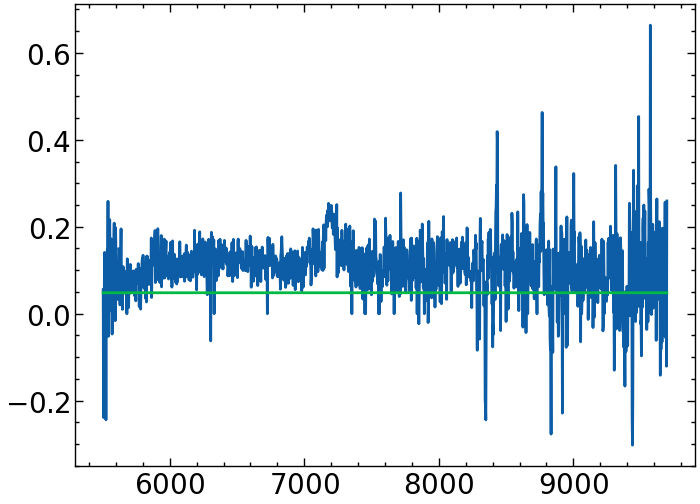

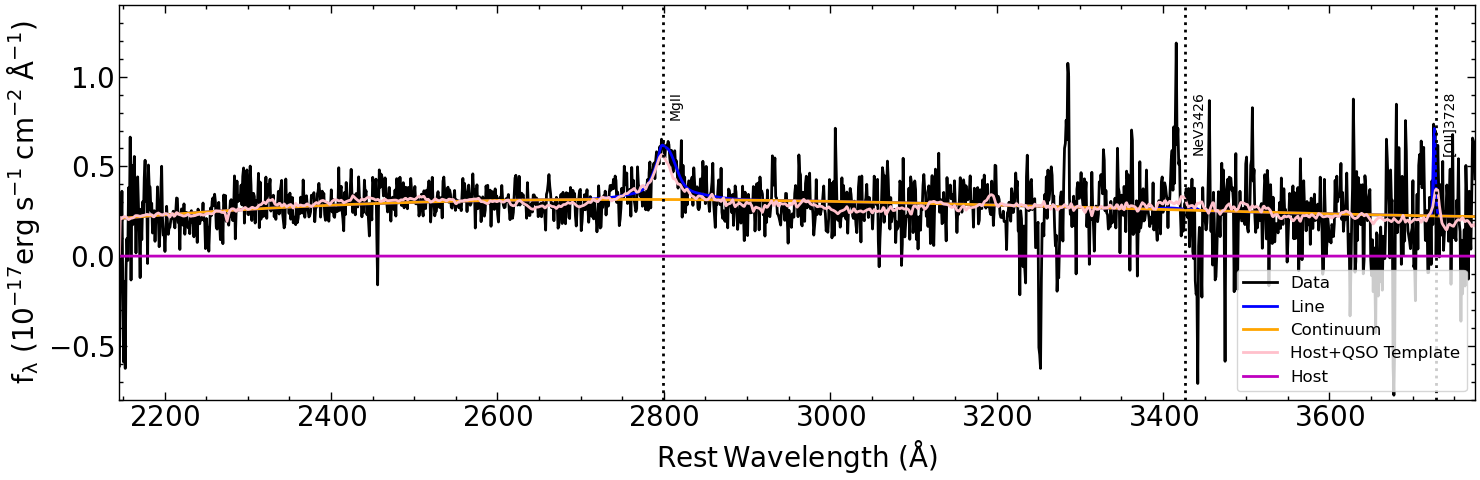

1350 ['-1.0']
1450 ['-1.0']
2200 ['43.90413290391513']
3000 ['44.161670547580655']
4200 ['-1.0']
5100 ['-1.0']
Lconti 44.161670547580655
Hb 0
MgII 3287.1180100525858
CIV 0
MASS
debug:
[2182.40603268 2183.45800218 2184.50997168 ... 3581.4242655  3582.476235
 3583.5282045 ] [ 0.04900461  0.42125626 -0.47352544 ... -0.04404648  0.05685922
  0.0569208 ] [4.30004744 4.22654553 4.18662777 ... 1.3119467  1.27568532 1.26140455]
debug:
[2182.40603268 2183.45800218 2184.50997168 ... 3581.4242655  3582.476235
 3583.5282045 ] [ 0.04900461  0.42125626 -0.47352544 ... -0.04404648  0.05685922
  0.0569208 ] [4.30004744 4.22654553 4.18662777 ... 1.3119467  1.27568532 1.26140455]


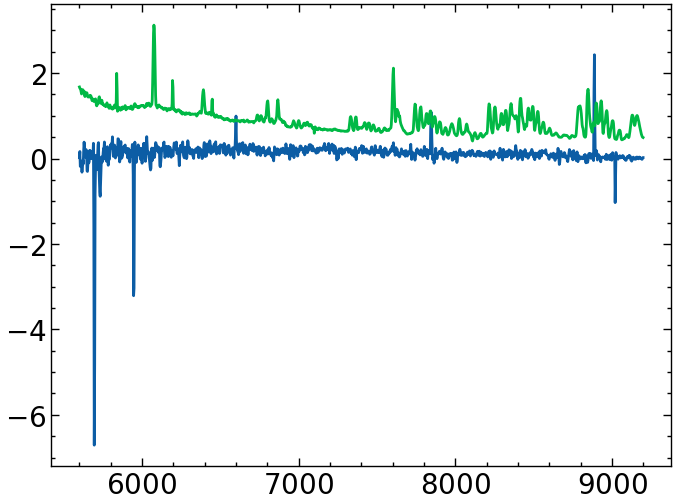

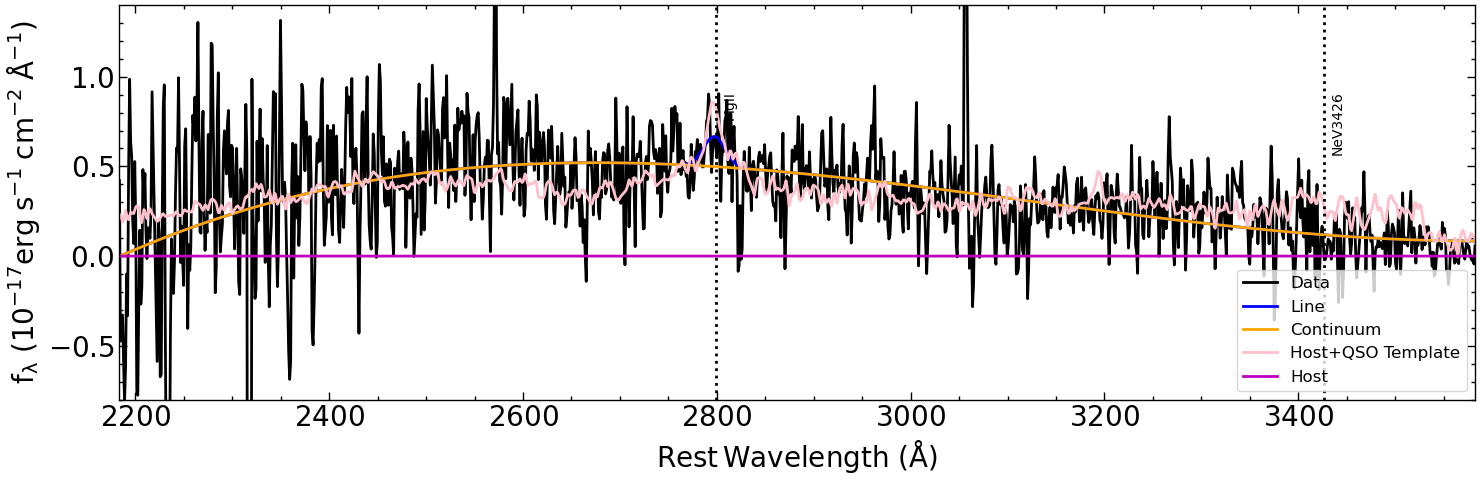

1350 ['-1.0']
1450 ['-1.0']
2200 ['43.11177518974912']
3000 ['44.27179036209767']
4200 ['-1.0']
5100 ['-1.0']
Lconti 44.27179036209767
Hb 0
MgII 2823.4474070016217
CIV 0
MASS
ID:: 228
ID:: 229
ID:: 230
ID:: 231
ID:: 232
ID:: 233
ID:: 234
ID:: 235
ID:: 236
ID:: 237
ID:: 238
ID:: 239
ID:: 240
ID:: 241
ID:: 242
ID:: 243
ID:: 244
ID:: 245
ID:: 246
ID:: 247
ID:: 248
ID:: 249
ID:: 250
ID:: 251
ID:: 252
ID:: 253
ID:: 254
ID:: 255
ID:: 256
ID:: 257
ID:: 258
ID:: 259
ID:: 260
ID:: 261
ID:: 262
ID:: 263
ID:: 264
ID:: 265
ID:: 266
ID:: 267
ID:: 268
ID:: 269
ID:: 270
ID:: 271
ID:: 272
ID:: 273
ID:: 274
ID:: 275
ID:: 276
ID:: 277
ID:: 278
ID:: 279
ID:: 280
ID:: 281
ID:: 282
ID:: 283
ID:: 284
ID:: 285
ID:: 286
ID:: 287
ID:: 288
ID:: 289
ID:: 290
ID:: 291
ID:: 292
ID:: 293
ID:: 294
ID:: 295
ID:: 296
ID:: 297
ID:: 298
ID:: 299
ID:: 300
ID:: 301
ID:: 302
ID:: 303
ID:: 304
ID:: 305
ID:: 306
ID:: 307
ID:: 308
ID:: 309
ID:: 310
ID:: 311
ID:: 312
ID:: 313
ID:: 314
ID:: 315
ID:: 316
ID:: 317
ID:: 318
ID:: 3

In [597]:
data_agn_BH = Table(np.array([-1]), names=['ID']) # dummy row

data_agn_BH['SNR'] = -1. # overall SNR of the spectrum
data_agn_BH['src'] = -1

data_agn_BH['flag_cal'] = 0


for c in cont_loc:
    data_agn_BH[f'L{c}'] = -1.

data_agn_BH['Lconti'] = -1.
data_agn_BH['Lbol'] = -1.

# Fiducial BH mass
data_agn_BH['M'] = -1.

data_agn_BH['M_Hb'] = -1.
data_agn_BH['M_MgII'] = -1.
data_agn_BH['M_CIV'] = -1.

data_agn_BH['M_Hb_line'] = -1.
data_agn_BH['M_MgII_line'] = -1.
data_agn_BH['M_CIV_line'] = -1.

data_agn_BH['M_Hb_e'] = -1.
data_agn_BH['M_MgII_e'] = -1.
data_agn_BH['M_CIV_e'] = -1.

data_agn_BH['M_Hb_line_e'] = -1.
data_agn_BH['M_MgII_line_e'] = -1.
data_agn_BH['M_CIV_line_e'] = -1.

# ADD FWHM and Luminosity
# TODO: Plot line luminosity detected vs redshift for different surveys

line_cen = np.array( [6564.60,            4862.68,    2797,    1908, 1549.06, 1215.67])
line_name = np.array([r'H$\alpha$+[NII]', r'H$\beta$','MgII'  , 'CIII]', 'CIV',   r'Ly$\alpha$'])

wmin = 4000
wmax = 11000

#for i,ID in enumerate(data_agn_download['ID'][z_count>1]): 
for i,ID in enumerate(data_agn_updated['ID']):

    flag = 0

    print('ID::', ID) # Empty or corrupt fits file
    if ID != 227: 
        continue
    
    ra = data_agn_updated['RAdeg'][i]
    dec = data_agn_updated['DEdeg'][i]

    z = data_agn_updated['z'][i]

    src = -1
    
    # zCOSMOS
    if os.path.isfile('spec/zCOSMOS/zcosmos_%d.fits'%ID): 

        print('zCOSMOS')

        src = 1
        
        hdu0 = fits.open('spec/zCOSMOS/zcosmos_%d.fits'%ID)
        data0 = hdu0[1].data
        wave = data0['WAVE'][0]
        flux = data0['FLUX_REDUCED'][0]/1e-17
        flux_err = np.full_like(flux, median_abs_deviation(flux, scale='normal', nan_policy='omit'))

        # artifact
        if ID==84:
            mask = wave > 3050
            wave = wave[mask]
            flux = flux[mask]
            flux_err = flux_err[mask]

        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave, flux, flux_err)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)
            
    # Magellan
    if os.path.isfile('spec/Magellan/magellan_%d.fits'%ID): 

        src = 2
        
        hdu1 = fits.open('spec/Magellan/magellan_%d.fits'%ID)
        data1 = hdu1[0].data
        wave = data1[0]
        flux = data1[1]/1e-17
        flux_err = data1[2]/1e-17
        mask =  data1[3]>0
        
        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave, flux, flux_err)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave[mask], flux[mask], flux_err[mask])

    # DEIMOS
    if os.path.isfile('spec/DEIMOS/deimos_%d.fits'%ID): 

        src = 3
        
        hdu3 = fits.open('spec/DEIMOS/deimos_%d.fits'%ID)
        
        data3 = hdu3[1].data
        if 'FLUX' not in data3.names:
            continue
        
        wave = data3['LAMBDA'][0]
        flux = data3['FLUX'][0]*1e-19/1e-17
        flux_err = np.full_like(flux, median_abs_deviation(flux, scale='normal', nan_policy='omit'))
        
        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave, flux, flux_err)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)
                
    # SDSS
    if os.path.isfile('spec/SDSS/sdss_%d.fits'%ID): 

        print('SDSS')
        
        src = 4
        
        hdu = fits.open('spec/SDSS/sdss_%d.fits'%ID)
        mask = np.isfinite(hdu[1].data['flux'])
        wave = 10**hdu[1].data['loglam'][mask]
        flux = hdu[1].data['flux'][mask]
        flux_err = 1/np.sqrt(hdu[1].data['ivar'][mask])
        
        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave, flux, flux_err)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # DESI
    if os.path.isfile('spec/desi/desi_%d.txt'%ID):

        src = 5
        
        data_spec = ascii.read('spec/desi/desi_%d.txt'%ID)

        wave = data_spec['col1']
        flux = data_spec['col2']
        flux_err = 1/np.sqrt(data_spec['col3'])
        
        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave, flux, flux_err)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # 3D-HST
    """
    if os.path.isfile('spec/3D HST/3dhst_%d.fits'%ID): 

        z_3dhst = data_agn_download['z_3dhst'][ID-1]
        
        hdu = fits.open('spec/3D HST/3dhst_%d.fits'%ID)
        flux_3dhst = hdu[1].data['flux']*hdu[1].data['sensitivity']
        ax.plot(hdu[1].data['wave'], flux_3dhst,
                 label=f'3D-HST (z={z_3dhst})', color='b', linewidth=1);
        
        mask = np.isfinite(flux_3dhst)
        ylim = np.max([ylim, np.nanmax(flux_3dhst[mask])])
    """  

    # FMOS
    def fmos(filename):
        hdu0 = fits.open(filename)
        flux_fmos = hdu0[0].data
        flux_fmos_err = np.full_like(flux_fmos, median_abs_deviation(flux_fmos, scale='normal', nan_policy='omit'))
        x_start = hdu0[0].header['CRVAL1'] # 15600
        x_stop = hdu0[0].header['CRVAL1'] + hdu0[0].header['NAXIS1']*hdu0[0].header['CD1_1'] # 15600+1920*1.25
        x_step = hdu0[0].header['CD1_1'] # 1.25
        wave = np.arange(x_start, x_stop, x_step)
        return wave, flux_fmos, flux_fmos_err

    # NOTE: FMOS are NIR spectra, not optical
    # # FMOS hl
    if os.path.isfile('spec/FMOS/fmos_%d_hl.fits'%ID): 
        src = 6
        wave, flux, flux_err = fmos('spec/FMOS/fmos_%d_hl.fits'%ID)
        
        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave, flux, flux_err)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # # FMOS jl
    if os.path.isfile('spec/FMOS/fmos_%d_jl.fits'%ID): 
        src = 7
        wave, flux, flux_err = fmos('spec/FMOS/fmos_%d_hl.fits'%ID)
        
        # FLUX CALIBR
        flux, flux_err, flag = flux_calib(ID, wave, flux, flux_err)
        data_agn_BH['flag_cal'][-1] = flag
        # DO THE FITTING
        measureMBH(ID, src, z, wave, flux, flux_err)

    # LEGA-C
    for legac_mask in list(range(1, 33))+list(range(101, 103)): 
        if os.path.isfile('spec/LEGA-C/legac_%d_M%d.fits'%(ID, legac_mask)):
            src = 8
            hdu0 = fits.open('spec/LEGA-C/legac_%d_M%d.fits'%(ID, legac_mask))
            wave =  hdu0[1].data['WAVE'][0]
            flux = hdu0[1].data['FLUX'][0]*1e-2
            flux_err = hdu0[1].data['ERR'][0]*1e-2
            
            # FLUX CALIBR
            flux, flux_err, flag = flux_calib(ID, wave, flux, flux_err)
            data_agn_BH['flag_cal'][-1] = flag
            # DO THE FITTING
            measureMBH(ID, src, z, wave, flux, flux_err)

Save the results:
Notes;
ID = 26, 31 post starburst galaxy (no AGN)
ID = 32, BL Lac? (AGN continuum, no broad-lines)


In [162]:
if flux_cal:
    ascii.write(data_agn_BH, 'data_agn_BH_fluxed.dat', overwrite=True)
else:
    ascii.write(data_agn_BH, 'data_agn_BH.dat', overwrite=True)

In [194]:
flux_cal = True

In [195]:
if flux_cal:
    data_agn_BH = ascii.read('data_agn_BH_fluxed.dat')
else:
    data_agn_BH = ascii.read('data_agn_BH.dat')

In [196]:
#data_agn_BH[data_agn_BH['flag_cal']==0]

In [197]:
# Only keep those with good flux calibration
data_agn_BH_cal = data_agn_BH[data_agn_BH['flag_cal']==1]
# Keep best SNR spectrum
data_agn_BH_tmp = data_agn_BH_cal.to_pandas()
data_agn_BH_tmp = data_agn_BH_tmp.loc[data_agn_BH_tmp.groupby('ID')['SNR'].idxmax()]
data_agn_BH_best = table.Table.from_pandas(data_agn_BH_tmp)
data_agn_BH_best

ID,SNR,src,flag_cal,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-1,-1.0,-1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,4.234844391228339,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46.010093214964364,46.9767042016463,-1.0,--,--,--,--,--,--,--,--,--,--,--,--
3,8.576215578737823,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.15277655383832,44.864583782879514,7.753036424533447,--,7.753036424533447,--,--,7.941988826102727,--,--,0.0,--,--,0.0,--
5,7.131585841678061,2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.1429707891569,44.72389576483252,8.397576281095972,8.397576281095972,--,--,8.093602127180567,--,--,0.0,--,--,0.0,--,--
6,19.42342354380822,8,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.80725160035027,45.38817657602589,8.21413043798444,8.21413043798444,--,--,7.933729875017943,--,--,0.0,--,--,0.0,--,--
8,4.668587661376708,4,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,45.76195281766987,46.473760046711064,8.930502661833106,--,8.930502661833106,8.911422248640411,--,8.824111559583322,9.104495990134046,--,0.0,0.0,--,0.0,0.0
9,0.16981907050457212,5,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,41.9905913385376,42.57151631421322,-1.0,--,--,--,--,--,--,--,--,--,--,--,--
10,1.8637222205662791,2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.170214176146146,44.88202140518734,-1.0,--,--,--,--,--,--,--,--,--,--,--,--
11,18.638766602481084,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.09454015215578,44.80634738119697,-1.0,--,--,--,--,--,--,--,--,--,--,--,--


In [198]:
data_agn_BH_best[(data_agn_BH_best['M']<7) & (data_agn_BH_best['M']>-1)]

ID,SNR,src,flag_cal,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
207,2.4546019736477733,2,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,42.02328087098179,42.735088100022985,6.578350345937177,--,6.578350345937177,--,--,8.350095400548216,--,--,0.0,--,--,0.0,--
243,0.8406474546652463,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,42.5815316745993,43.54814266128123,6.979748894026556,--,--,6.979748894026556,--,--,8.50292962362489,--,--,0.0,--,--,0.0


### Analyze

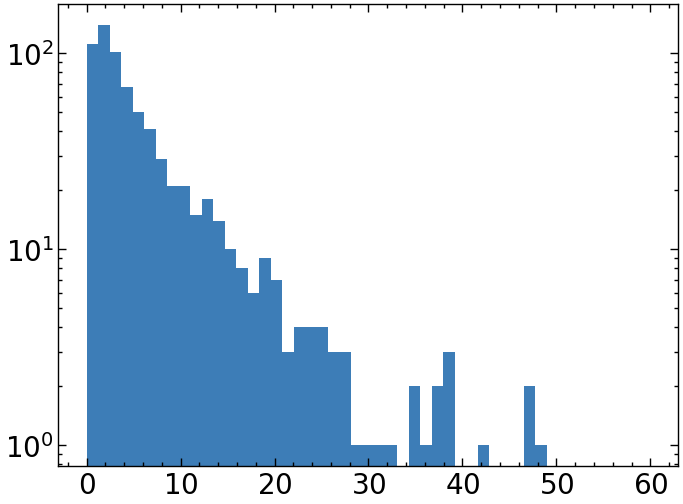

In [199]:

plt.hist(data_agn_BH['SNR'], label='3000', alpha=0.8, bins=np.linspace(0, 60), log=True);

In [200]:
#data_agn_BH['SNR']

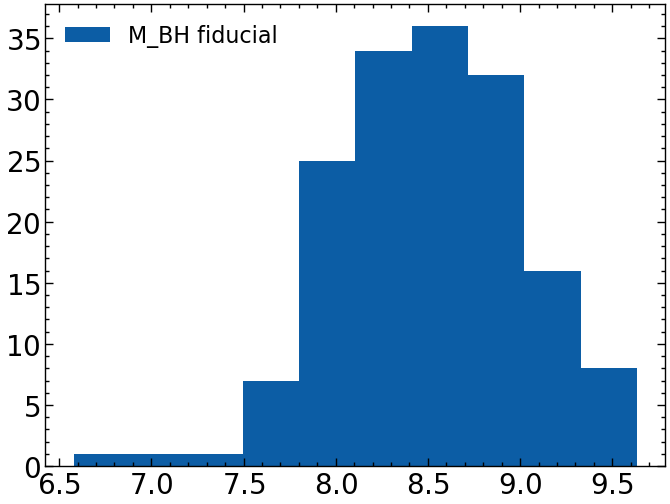

In [201]:
plt.hist(data_agn_BH_best['M'][data_agn_BH_best['M']>0], label='M_BH fiducial')
plt.legend()

0.4963047290549039


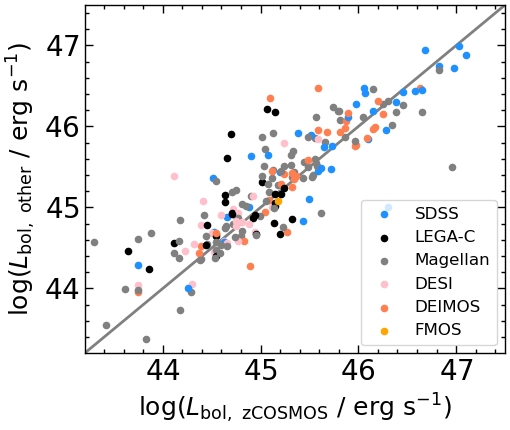

In [365]:
mask_sdss = data_agn_BH['src']==1
dms = []
fig, ax = plt.subplots(1,1, figsize=(5.3, 4.5))

## TODO: throw out ones with galaxy > Lconti AGN

colors = ['k', 'k', 'gray', 'coral', 'dodgerblue', 'pink', 'orange', 'orange', 'k']
labels = ['', 'zCOSMOS', 'Magellan', 'DEIMOS', 'SDSS', 'DESI', 'FMOS', 'FMOS', 'LEGA-C']

x = np.linspace(41, 49)
ax.plot(x, x, color='gray', zorder=-1)
#ax.plot(x, x-0.2, color='k', linestyle='dashed', zorder=-1)
#ax.plot(x, x+0.2, color='k', linestyle='dashed', zorder=-1)

dm_store = []

for id in data_agn_BH['ID'][mask_sdss]:
    mask = (data_agn_BH['ID']==id)
    # SDSS
    m_sdss = data_agn_BH['Lbol'][mask & mask_sdss]
    # non-SDSS
    m_matches = data_agn_BH['Lbol'][mask & ~mask_sdss]
    src_matches = data_agn_BH['src'][mask & ~mask_sdss]
    #print(src_matches)
    for i, dmi in enumerate(m_matches):
        if dmi > 0:
            if (flux_cal==False) or (flux_cal==True and data_agn_BH['flag_cal'][mask & ~mask_sdss][i]==1):
                ax.scatter(m_sdss, dmi, color=colors[src_matches[i-1]], label=labels[src_matches[i-1]], s=20)
                dm_store.append(np.abs(dmi - m_sdss))

ax.set_xlabel(r'$\log(L_{\rm{bol,\ zCOSMOS}}\ /\ \rm{erg\ s}^{-1})$', fontsize=18)
ax.set_ylabel(r'$\log(L_{\rm{bol,\ other}}\ /\ \rm{erg\ s}^{-1})$', fontsize=18)

print(np.std(dm_store))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12, frameon=True, loc=4)

ax.set_xlim(43.2, 47.5)
ax.set_ylim(43.2, 47.5)

fig.tight_layout()
if flux_cal:
    fig.savefig('Lbol_fluxed.pdf', dpi=300)
else:
    fig.savefig('Lbol.pdf', dpi=300)

In [368]:
(.5)/44

0.011363636363636364

In [203]:
data_agn_BH[data_agn_BH['flag_cal']==-1]

ID,SNR,src,flag_cal,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
490,38.90767401986635,8,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.257605881575394,44.969413110616586,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [204]:
data_agn_BH[data_agn_BH['flag_cal']==-1]

ID,SNR,src,flag_cal,L1350,L1450,L2200,L3000,L4200,L5100,Lconti,Lbol,M,M_Hb,M_MgII,M_CIV,M_Hb_line,M_MgII_line,M_CIV_line,M_Hb_e,M_MgII_e,M_CIV_e,M_Hb_line_e,M_MgII_line_e,M_CIV_line_e
int64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
490,38.90767401986635,8,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.257605881575394,44.969413110616586,-1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


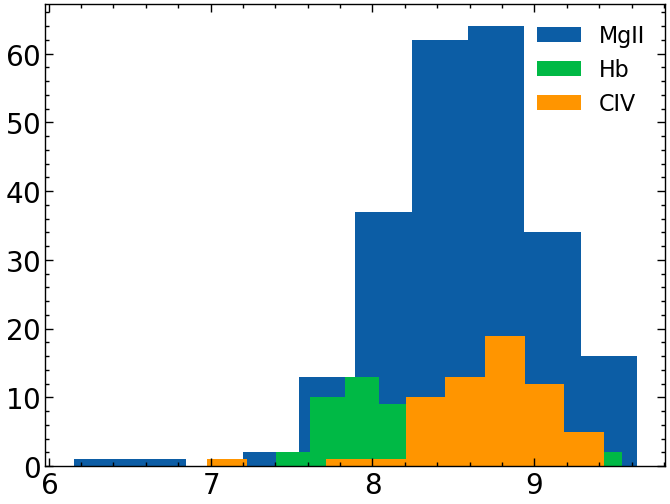

In [205]:
plt.hist(data_agn_BH['M_MgII'][data_agn_BH['M_MgII']>0], label='MgII')
plt.hist(data_agn_BH['M_Hb'][data_agn_BH['M_Hb']>0], label='Hb')
plt.hist(data_agn_BH['M_CIV'][data_agn_BH['M_CIV']>0], label='CIV')
plt.legend()

### Host Mass relation

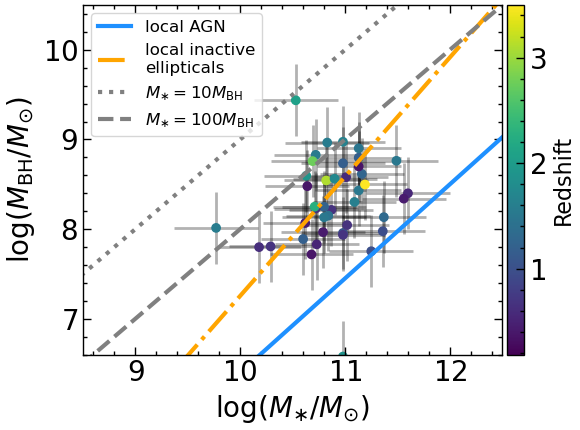

In [206]:
data_sed = ascii.read('table_mass.dat')
data_join = table.join(data_sed, data_agn_BH_best, keys='ID')
data_join = table.join(data_agn_updated, data_join, keys='ID')
cat_join = SkyCoord(data_join['RAdeg'], data_join['DEdeg'], unit='deg')
mask_chi2 = (data_join['SF_excess'] > 1.2) & (data_join['chi2'] < 5) # This selects against very luminous AGNs / high BHs or non SF galaxies

fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

#
x = np.logspace(8, 13)
ax.plot(np.log10(x), 7.45 + 1.05*np.log10(x/1e11), lw=3, label='local AGN', color='dodgerblue')
ax.plot(np.log10(x), 7.89 + 1.33*np.log10(x/3e10), lw=3, label='local inactive\nellipticals', linestyle='dashdot', color='orange')

ax.plot(np.log10(x), np.log10(x/10) , linestyle='dotted', color='gray', lw=3, label=r'$M_{\ast}=10 M_{\rm{BH}}$')
ax.plot(np.log10(x), np.log10(x/100), linestyle='dashed', color='gray', lw=3, label=r'$M_{\ast}=100 M_{\rm{BH}}$')

im = ax.scatter(data_join['logMs'][mask_chi2], data_join['M'][mask_chi2], c=data_join['z'][mask_chi2],
                marker='o')

ax.errorbar(data_join['logMs'][mask_chi2], data_join['M'][mask_chi2], c='k', zorder=-1,
                 xerr=0.4, yerr=0.4, marker=None, linestyle='none', alpha=0.3)

#ax.errorbar(data_join['logMs'][mask_chi2], data_join['M_CIV'][mask_chi2], yerr=0.4, xerr=0.4,  marker='o', linestyle='none', label='CIV')
#ax.errorbar(data_join['logMs'][mask_chi2], data_join['M_Hb'][mask_chi2], yerr=0.4, xerr=0.4,  marker='o', linestyle='none', label='Hb')
ax.legend(fontsize=12, frameon=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'Redshift')

ax.set_xlim(8.5, 12.5)
ax.set_ylim(6.6, 10.5)

ax.set_ylabel(r'$\log(M_{\rm{BH}} / M_{\odot})$', fontsize=20)
ax.set_xlabel(r'$\log(M_{\ast} / M_{\odot})$', fontsize=20)

fig.tight_layout()
fig.savefig('hostrel.pdf', dpi=300)


# Color by redshift
# Check with Jennifers paper
# Seems consistent with Fabio's result https://arxiv.org/pdf/2308.12331.pdf

47


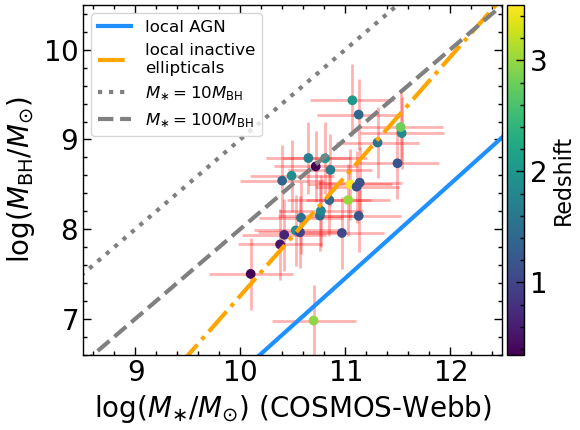

In [207]:
data_mingyang = ascii.read('COSMOS-Web_AGN1_paper.dat')
coord_mingyang = SkyCoord(data_mingyang['RA'],data_mingyang['DEC'], unit='deg')

idx_agn, idx_mingyang, d2d, d3d = coord_mingyang.search_around_sky(cat_join, 0.5*u.arcsec)
print(len(idx_mingyang))

fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

#
x = np.logspace(8, 13)
ax.plot(np.log10(x), 7.45 + 1.05*np.log10(x/1e11), lw=3, label='local AGN', color='dodgerblue')
ax.plot(np.log10(x), 7.89 + 1.33*np.log10(x/3e10), lw=3, label='local inactive\nellipticals', linestyle='dashdot', color='orange')


ax.plot(np.log10(x), np.log10(x/10) , linestyle='dotted', color='gray', lw=3, label=r'$M_{\ast}=10 M_{\rm{BH}}$')
ax.plot(np.log10(x), np.log10(x/100), linestyle='dashed', color='gray', lw=3, label=r'$M_{\ast}=100 M_{\rm{BH}}$')

im = ax.scatter(data_mingyang['logMs'][idx_mingyang], data_join['M'][idx_agn], c=data_join['z'][idx_agn],
                marker='o')

ax.errorbar(data_mingyang['logMs'][idx_mingyang], data_join['M'][idx_agn], c='r', zorder=-1,
                 xerr=0.4, yerr=0.4, marker=None, linestyle='none', alpha=0.3)

#ax.errorbar(data_join['logMs'][mask_chi2], data_join['M_CIV'][mask_chi2], yerr=0.4, xerr=0.4,  marker='o', linestyle='none', label='CIV')
#ax.errorbar(data_join['logMs'][mask_chi2], data_join['M_Hb'][mask_chi2], yerr=0.4, xerr=0.4,  marker='o', linestyle='none', label='Hb')
ax.legend(fontsize=12, frameon=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'Redshift')

ax.set_xlim(8.5, 12.5)
ax.set_ylim(6.6, 10.5)

ax.set_ylabel(r'$\log(M_{\rm{BH}} / M_{\odot})$', fontsize=20)
ax.set_xlabel(r'$\log(M_{\ast} / M_{\odot})$ (COSMOS-Webb)', fontsize=20)

fig.tight_layout()
fig.savefig('hostrel_webb.pdf', dpi=300)


# Color by redshift
# Check with Jennifers paper
# Seems consistent with Fabio's result https://arxiv.org/pdf/2308.12331.pdf

In [130]:
#data_mingyang

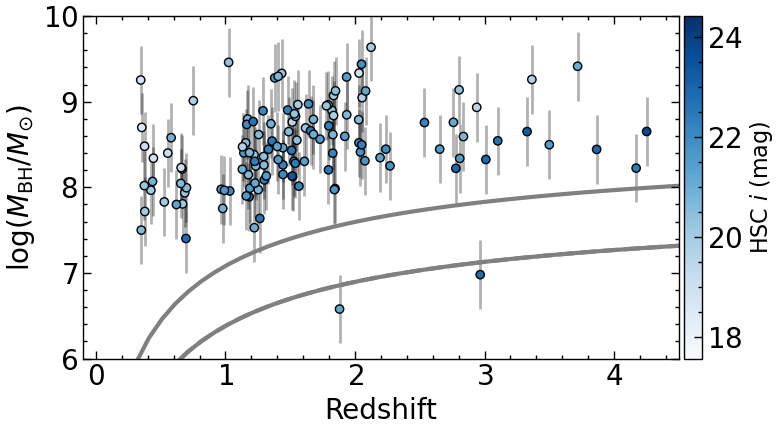

In [209]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

data_sed = ascii.read('table_mass.dat')
data_join = table.join(data_sed, data_agn_BH_best, keys='ID')
data_join = table.join(data_agn_updated, data_join, keys='ID')

fig, ax = plt.subplots(1,1, figsize=(8, 4.5))

im = ax.scatter(data_join['z'], data_join['M'],
                c=data_join['i-mag'], cmap='Blues',
                marker='o', edgecolors='k', label='spec-z')

ax.errorbar(data_join['z'], data_join['M'],
            yerr=0.4, marker=None, linestyle='none', color='k', zorder=-1, alpha=0.3)


#ax.legend(loc=4, frameon=True)
ax.set_xlabel('Redshift', fontsize=20)
ax.set_ylabel(r'$\log(M_{\rm{BH}} / M_{\odot})$', fontsize=20)

ax.set_xlim(-.1, 4.5)
ax.set_ylim(6.0, 10)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'HSC $i$ (mag)')

a = -4.7
b = -1.9
m5 = 25.5
gamma = 0.039
SFinf = 0.1
zs = np.linspace(0, 5)
d_pc = cosmo.luminosity_distance(zs).to(u.pc).value
alpha = 1.0 # for galaxies
K = -2.5*(1 + alpha) * np.log10(1 + zs) # K-correction
logM = 1/b*(2.5 * np.log10(SFinf * gamma**-1/2) - a - 5 * np.log10(d_pc) + 5 - K + m5 )

# BHs are much bigger compared to their hosts, so should outshine host more easily

ax.set_autoscale_on(False)
ax.plot(zs, logM, lw=3, color='gray', zorder=-1)
ax.plot(zs, logM+0.7, lw=3, color='gray', zorder=-1)


#m5 = 26.5
#logM = 1/b*(2.5 * np.log10(SFinf * gamma**-1/2) - a - 5 * np.log10(d_pc) + 5 - K + m5 )

ax.plot(zs, logM, lw=3, color='gray', zorder=-1, linestyle='dashed')


fig.tight_layout()
fig.savefig('bhmassredshift.pdf', dpi=300)

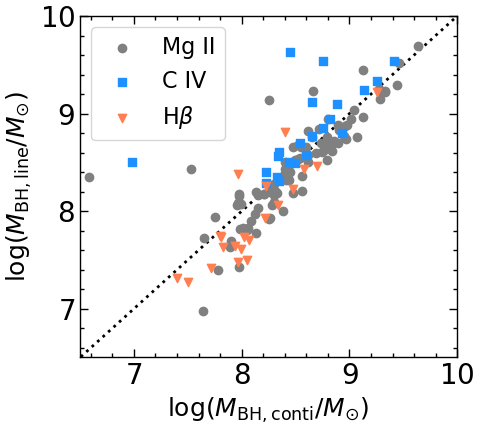

In [136]:
# TODO: Line SNR > 2

fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

#
x = np.logspace(5, 13)
ax.plot(np.log10(x), np.log10(x/1) , linestyle='dotted', color='k', zorder=-1)

ax.scatter(data_join['M_MgII'], data_join['M_MgII_line'], label='Mg II', color='gray', marker='o')
ax.scatter(data_join['M_CIV'], data_join['M_CIV_line'], label='C IV', color='dodgerblue', marker='s')
ax.scatter(data_join['M_Hb'], data_join['M_Hb_line'], label=r'H$\beta$', color='coral', marker='v')
ax.legend(frameon=True)
ax.set_xlim(6.5, 10)
ax.set_ylim(6.5, 10)

ax.set_xlabel(r'$\log(M_{\rm{BH}, conti} / M_{\odot})$', fontsize=18)
ax.set_ylabel(r'$\log(M_{\rm{BH}, line} / M_{\odot})$', fontsize=18)

fig.tight_layout()
fig.savefig('conti.pdf', dpi=300)

### X-ray properties

In [527]:
# Match data_join to Chandra-COSMOS and get the 2-10 keV luminosity

data_cosmos2020j = ascii.read('data_cosmos2020j.dat')

cat_chandra = SkyCoord(data_cosmos2020j['ALPHA_J2000'], data_cosmos2020j['DELTA_J2000'], unit='deg')
cat_join = SkyCoord(data_join['RAdeg'], data_join['DEdeg'], unit='deg')

idx_join, idx_chandra, d2d, d3d = cat_chandra.search_around_sky(cat_join, 0.6*u.arcsec)

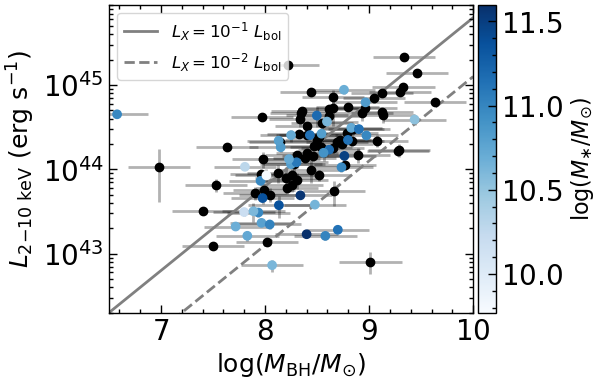

In [548]:
import scipy.constants as cst
nu_1keV = 1e3*cst.eV / cst.h

fig, ax = plt.subplots(1,1, figsize=(5, 4))
Eup = 10
Elo = 0.5

# Convert X-ray flux to luminosity

Fx = data_cosmos2020j[idx_chandra]['HARD_FLUX'].data
Fx_err = data_cosmos2020j[idx_chandra]['HARD_FLUXERR'].data
Fx[Fx.mask==True] = -1
Fx[(Fx=='---')] = -1
Fx = Fx.compressed().astype(float)
Fx_err[Fx_err.mask==True] = -1
Fx_err[(Fx_err=='---')] = -1
Fx_err = Fx_err.compressed().astype(float)

# Use 2-10

# 
dL = cosmo.luminosity_distance(data_join['z'][idx_join]).to(u.cm).value
LX = (Fx*(4*np.pi*dL**2))
dLX = (Fx_err*(4*np.pi*dL**2))


mask = (data_join['M'][idx_join] > 0 ) & (LX > 0) & (dLX > 0)

ax.scatter(data_join['M'][idx_join][mask & ~mask_chi2], LX[mask & ~mask_chi2], marker='o', c='k')
im = ax.scatter(data_join['M'][idx_join][mask & mask_chi2], LX[mask & mask_chi2], marker='o',
                c=data_join['logMs'][idx_join][mask & mask_chi2], cmap='Blues')

ax.errorbar(data_join['M'][idx_join][mask], LX[mask], yerr=dLX[mask], xerr=0.3, linestyle='none', c='k', zorder=-1, alpha=0.3)


# L_bol = 10
x = np.linspace(6, 10)
L_Edd = 1.26*1e38*10**x / 10
ax.plot(x, 0.05*L_Edd, label=r'$L_{X}{=}10^{-1}\ L_{\rm{bol}}$', color='gray', zorder=-1)
ax.plot(x, 0.01*L_Edd, label=r'$L_{X}{=}10^{-2}\ L_{\rm{bol}}$', color='gray', zorder=-1, linestyle='dashed')
#ax.plot(x, 0.001*L_Edd, label=r'$L_{X}{=}10^{-3} L_{\rm{bol}}$', color='gray', zorder=-1, linestyle='dotted')

ax.legend(fontsize=12, frameon=True)


ax.set_yscale('log')
ax.set_xlabel(r'$\log(M_{\rm{BH}} / M_{\odot})$', fontsize=18)
ax.set_ylabel(r'$L_{2{-}10\ {\rm{keV}}}\ ({\rm{erg\ s}}^{-1}$)', fontsize=18)

ax.set_xlim(6.5, 10)
ax.set_ylim(2e42, 9e45)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'$\log(M_{\ast} / M_{\odot})$')

fig.savefig('xray.pdf', dpi=300)